In [1]:
from benchmark_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = BenchmarkResult()

# Run fixed trial benchmarks (5 trials)
for trial in range(1, 6):
    print(f"\n=== Trial {trial} ===")
    run_query("MySQL", trial, results)
    run_query("MongoDB", trial, results)
    run_update("MySQL", trial, results)
    run_update("MongoDB", trial, results)
    run_aggregate("MySQL", trial, results)
    run_aggregate("MongoDB", trial, results)

# Storage checks
check_storage("MySQL", results)
check_storage("MongoDB", results)

# Scalability tests (3 trials per size)
data_sizes = [100_000, 500_000, 1_000_000]
for size in data_sizes:
    for trial in range(1, 4):
        print(f"\nRunning scalability test: MySQL with {size:,} rows, Trial {trial}")
        df = generate_fake_data(size)
        run_insert(db_type="MySQL", trial=f"{size}_{trial}", tracker=results, df=df, drop_existing=True)
        print(f"\nRunning scalability test: MongoDB with {size:,} rows, Trial {trial}")
        run_insert(db_type="MongoDB", trial=f"{size}_{trial}", tracker=results, df=df, drop_existing=True)

# Save and summarize
results.to_df().to_csv("benchmark_log.csv", index=False)
results.summary()


=== Trial 1 ===

⏱ SELECT on MySQL (Trial 1):
   Time: 8.41s | CPU: 1.2% | RAM: 176.25 MB

⏱ SELECT on MongoDB (Trial 1):
   Time: 5.04s | CPU: 3.1% | RAM: 378.52 MB

⏱ UPDATE on MySQL (Trial 1):
   Time: 1.74s | CPU: 0.0% | RAM: 3.22 MB

⏱ UPDATE on MongoDB (Trial 1):
   Time: 2.81s | CPU: 0.0% | RAM: 0.43 MB

⏱ AGGREGATE on MySQL (Trial 1):
   Time: 5.49s | CPU: 0.0% | RAM: 0.02 MB

⏱ AGGREGATE on MongoDB (Trial 1):
   Time: 0.59s | CPU: 0.0% | RAM: 0.11 MB

=== Trial 2 ===

⏱ SELECT on MySQL (Trial 2):
   Time: 8.46s | CPU: 2.4% | RAM: 169.19 MB

⏱ SELECT on MongoDB (Trial 2):
   Time: 5.45s | CPU: 2.1% | RAM: 448.70 MB

⏱ UPDATE on MySQL (Trial 2):
   Time: 1.93s | CPU: 0.0% | RAM: 0.56 MB

⏱ UPDATE on MongoDB (Trial 2):
   Time: 1.30s | CPU: 0.0% | RAM: 0.39 MB

⏱ AGGREGATE on MySQL (Trial 2):
   Time: 6.67s | CPU: 0.0% | RAM: 0.02 MB

⏱ AGGREGATE on MongoDB (Trial 2):
   Time: 0.94s | CPU: 0.0% | RAM: 0.12 MB

=== Trial 3 ===

⏱ SELECT on MySQL (Trial 3):
   Time: 11.08s | CPU: 

{'timing':    operation database  avg_value  min_value  max_value  runs
 0  aggregate  MongoDB      0.993      0.586      1.739     5
 1  aggregate    MySQL      6.979      5.490      8.237     5
 2     insert  MongoDB     17.401      3.007     31.712     9
 3     insert    MySQL     64.270     10.406    121.441     9
 4     select  MongoDB      5.050      4.190      5.453     5
 5     select    MySQL     10.737      8.410     14.670     5
 6     update  MongoDB      1.866      1.300      2.811     5
 7     update    MySQL      2.033      1.745      2.387     5,
 'storage':     operation database  avg_value  min_value  max_value  runs
 0  storage_mb  MongoDB    174.409    174.409    174.409     1
 1  storage_mb    MySQL     84.609     84.609     84.609     1,
 'updates':         operation database  avg_value  min_value  max_value  runs
 0  update_success  MongoDB    23377.0    23377.0    23377.0     5
 1  update_success    MySQL    23377.0    23377.0    23377.0     5,
 'accuracy':     

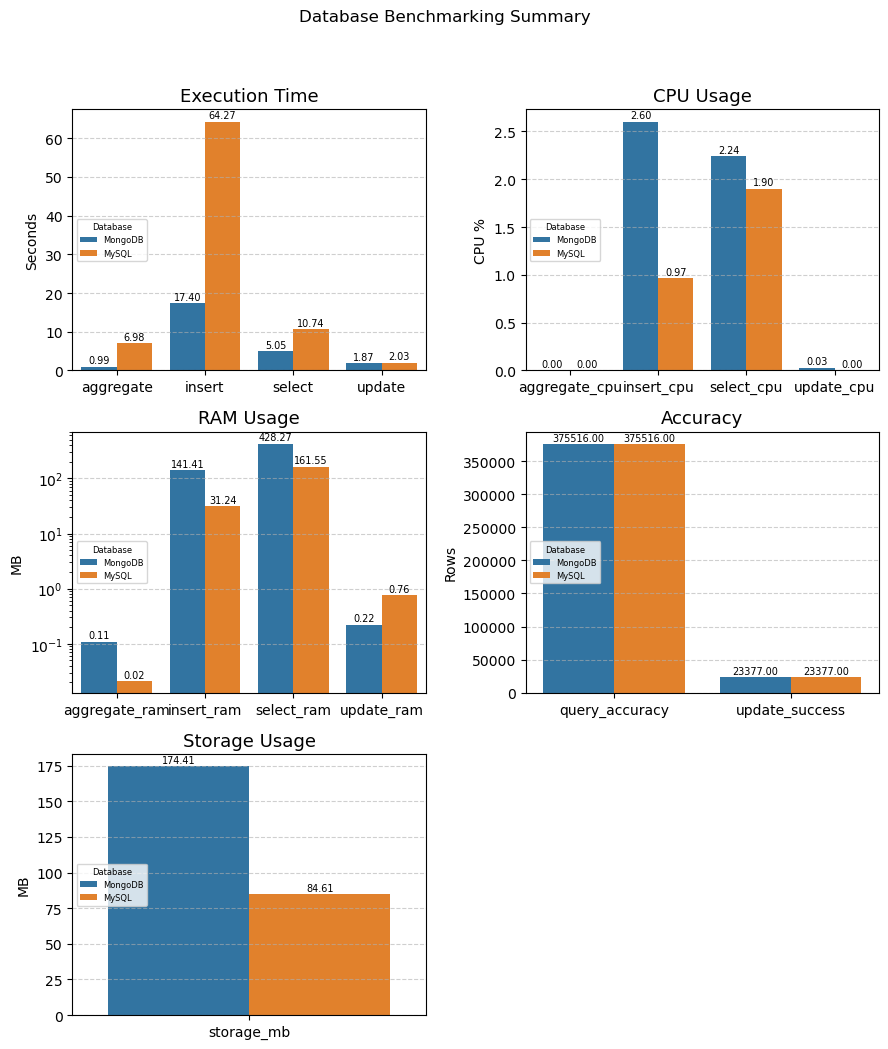

In [2]:
# Load the benchmark results
df = pd.read_csv("benchmark_log.csv")

# Summarize the data
summary_df = df.groupby(["operation", "database"]).agg(
    avg_value=("value", "mean"),
    std_value=("value", "std"),  # Add standard deviation
    min_value=("value", "min"),
    max_value=("value", "max"),
    runs=("value", "count")
).reset_index()

# Define metric groups
time_ops = ["insert", "select", "update", "aggregate"]
cpu_ops = [f"{op}_cpu" for op in time_ops]
ram_ops = [f"{op}_ram" for op in time_ops]
accuracy_ops = ["query_accuracy", "update_success"]
storage_ops = ["storage_mb"]

# Create the figure and axes
fig, axes = plt.subplots(3, 2, figsize=(9, 11))
fig.suptitle("Database Benchmarking Summary")

# Helper function to draw a barplot with labels
def draw_plot(ax, data, title, ylabel, log_scale=False):
    sns.barplot(data=data, x="operation", y="avg_value", hue="database", ax=ax)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=1, fontsize=7)
    ax.set_title(title, fontsize=13)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    if log_scale:
        ax.set_yscale("log")
    ax.legend(title="Database", loc="center left", fontsize=6, title_fontsize=6)

# Plot each group
draw_plot(axes[0, 0], summary_df[summary_df["operation"].isin(time_ops)], "Execution Time", "Seconds")
draw_plot(axes[0, 1], summary_df[summary_df["operation"].isin(cpu_ops)], "CPU Usage", "CPU %")
draw_plot(axes[1, 0], summary_df[summary_df["operation"].isin(ram_ops)], "RAM Usage", "MB", log_scale=True)
draw_plot(axes[1, 1], summary_df[summary_df["operation"].isin(accuracy_ops)], "Accuracy", "Rows")
draw_plot(axes[2, 0], summary_df[summary_df["operation"].isin(storage_ops)], "Storage Usage", "MB")

# Hide the unused subplot (bottom right)
axes[2, 1].axis("off")

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [3]:
# Get query accuracy rows
accuracy = summary_df[summary_df["operation"] == "query_accuracy"].copy()

# Extract max value (ideal) as baseline for accuracy %
max_accuracy = accuracy["avg_value"].max()

# Add percentage column
accuracy["accuracy_percent"] = (accuracy["avg_value"] / max_accuracy * 100).round(2)

# Preview
accuracy

,operation,database,avg_value,std_value,min_value,max_value,runs,accuracy_percent
12,query_accuracy,MongoDB,375516.0,0.0,375516.0,375516.0,5,100.0
13,query_accuracy,MySQL,375516.0,0.0,375516.0,375516.0,5,100.0


In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tabulate import tabulate

# Data from BenchmarkResult.summary()
data = {
    "Execution Time (sec)": [
        {"operation": "aggregate", "database": "MongoDB", "avg_value": 0.993, "min_value": 0.586, "max_value": 1.739, "runs": 5},
        {"operation": "aggregate", "database": "MySQL", "avg_value": 6.979, "min_value": 5.49, "max_value": 8.237, "runs": 5},
        {"operation": "insert", "database": "MongoDB", "avg_value": 17.401, "min_value": 3.007, "max_value": 31.712, "runs": 9},
        {"operation": "insert", "database": "MySQL", "avg_value": 64.270, "min_value": 10.406, "max_value": 121.441, "runs": 9},
        {"operation": "select", "database": "MongoDB", "avg_value": 5.050, "min_value": 4.19, "max_value": 5.453, "runs": 5},
        {"operation": "select", "database": "MySQL", "avg_value": 10.737, "min_value": 8.41, "max_value": 14.67, "runs": 5},
        {"operation": "update", "database": "MongoDB", "avg_value": 1.866, "min_value": 1.3, "max_value": 2.811, "runs": 5},
        {"operation": "update", "database": "MySQL", "avg_value": 2.033, "min_value": 1.745, "max_value": 2.387, "runs": 5},
    ],
    "Storage Usage (MB)": [
        {"operation": "storage_mb", "database": "MongoDB", "avg_value": 174.409, "min_value": 174.409, "max_value": 174.409, "runs": 1},
        {"operation": "storage_mb", "database": "MySQL", "avg_value": 84.609, "min_value": 84.609, "max_value": 84.609, "runs": 1},
    ],
    "Update Success (rows)": [
        {"operation": "update_success", "database": "MongoDB", "avg_value": 23377, "min_value": 23377, "max_value": 23377, "runs": 5},
        {"operation": "update_success", "database": "MySQL", "avg_value": 23377, "min_value": 23377, "max_value": 23377, "runs": 5},
    ],
    "Query Accuracy (rows)": [
        {"operation": "query_accuracy", "database": "MongoDB", "avg_value": 375516, "min_value": 375516, "max_value": 375516, "runs": 5},
        {"operation": "query_accuracy", "database": "MySQL", "avg_value": 375516, "min_value": 375516, "max_value": 375516, "runs": 5},
    ],
    "CPU Usage (%)": [
        {"operation": "aggregate_cpu", "database": "MongoDB", "avg_value": 0.24, "min_value": 0.2, "max_value": 0.2, "runs": 5},
        {"operation": "aggregate_cpu", "database": "MySQL", "avg_value": 0.2, "min_value": 0.2, "max_value": 0.2, "runs": 5},
        {"operation": "insert_cpu", "database": "MongoDB", "avg_value": 2.601, "min_value": 2.089, "max_value": 3.81, "runs": 9},
        {"operation": "insert_cpu", "database": "MySQL", "avg_value": 0.967, "min_value": 0.851, "max_value": 1.361, "runs": 9},
        {"operation": "select_cpu", "database": "MongoDB", "avg_value": 2.241, "min_value": 1.627, "max_value": 3.14, "runs": 5},
        {"operation": "select_cpu", "database": "MySQL", "avg_value": 1.899, "min_value": 1.188, "max_value": 2.647, "runs": 5},
        {"operation": "update_cpu", "database": "MongoDB", "avg_value": 0.227, "min_value": 0.2, "max_value": 0.137, "runs": 5},
        {"operation": "update_cpu", "database": "MySQL", "avg_value": 0.2, "min_value": 0.2, "max_value": 0.2, "runs": 5},
    ],
    "RAM Usage (MB)": [
        {"operation": "aggregate_ram", "database": "MongoDB", "avg_value": 0.109, "min_value": 0.294, "max_value": 0.121, "runs": 5},
        {"operation": "aggregate_ram", "database": "MySQL", "avg_value": 0.221, "min_value": 0.22, "max_value": 0.223, "runs": 5},
        {"operation": "insert_ram", "database": "MongoDB", "avg_value": 141.414, "min_value": 38.113, "max_value": 283.48, "runs": 9},
        {"operation": "insert_ram", "database": "MySQL", "avg_value": 31.243, "min_value": 7.082, "max_value": 61.078, "runs": 9},
        {"operation": "select_ram", "database": "MongoDB", "avg_value": 428.267, "min_value": 378.516, "max_value": 448.703, "runs": 5},
        {"operation": "select_ram", "database": "MySQL", "avg_value": 161.548, "min_value": 145.648, "max_value": 176.246, "runs": 5},
        {"operation": "update_ram", "database": "MongoDB", "avg_value": 0.221, "min_value": 0.294, "max_value": 0.426, "runs": 5},
        {"operation": "update_ram", "database": "MySQL", "avg_value": 0.765, "min_value": 0.2, "max_value": 3.223, "runs": 5},
    ]
}

# Function to calculate standard deviation (approximation from min/max)
def calculate_sd(avg, min_val, max_val, n):
    # Approximate SD assuming uniform distribution between min and max
    if n <= 1:
        return 0
    # Use range-based approximation: SD ≈ (max - min) / √12 for uniform distribution
    # Adjust for sample size and assume normal distribution for simplicity
    range_est = (max_val - min_val) / np.sqrt(12)
    return range_est * np.sqrt(n / (n - 1))

# Function to calculate 95% CI
def calculate_ci(mean, sd, n, confidence=0.95):
    if n <= 1 or sd == 0:
        return [mean, mean]
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin = t_value * (sd / np.sqrt(n))
    return [round(mean - margin, 3), round(mean + margin, 3)]

# Function to perform t-test
def perform_ttest(mean1, sd1, n1, mean2, sd2, n2):
    if sd1 == 0 or sd2 == 0 or n1 <= 1 or n2 <= 1:
        return "N/A", "N/A"
    t_stat, p_val = stats.ttest_ind_from_stats(mean1, sd1, n1, mean2, sd2, n2, equal_var=False)
    return round(t_stat, 3), round(p_val, 3)

# Statistical Analysis
for metric, entries in data.items():
    print(f"\n**Statistical Analysis: {metric}**")
    table_data = []
    for i in range(0, len(entries), 2):  # Process pairs (MongoDB vs MySQL)
        op1, op2 = entries[i], entries[i+1]
        if op1["database"] == "MongoDB":
            mongo, mysql = op1, op2
        else:
            mongo, mysql = op2, op1

        # Calculate SD
        sd_mongo = calculate_sd(mongo["avg_value"], mongo["min_value"], mongo["max_value"], mongo["runs"])
        sd_mysql = calculate_sd(mysql["avg_value"], mysql["min_value"], mysql["max_value"], mysql["runs"])

        # Calculate 95% CI
        ci_mongo = calculate_ci(mongo["avg_value"], sd_mongo, mongo["runs"])
        ci_mysql = calculate_ci(mysql["avg_value"], sd_mysql, mysql["runs"])

        # Perform t-test
        t_stat, p_val = perform_ttest(mongo["avg_value"], sd_mongo, mongo["runs"],
                                      mysql["avg_value"], sd_mysql, mysql["runs"])

        # Prepare table row
        table_data.append([
            mongo["operation"],
            f"{mongo['avg_value']:.3f}",
            f"{sd_mongo:.3f}",
            f"[{ci_mongo[0]:.3f}, {ci_mongo[1]:.3f}]",
            f"{mysql['avg_value']:.3f}",
            f"{sd_mysql:.3f}",
            f"[{ci_mysql[0]:.3f}, {ci_mysql[1]:.3f}]",
            t_stat,
            p_val
        ])

    # Display table
    headers = ["Operation", "MongoDB Mean", "MongoDB SD", "MongoDB 95% CI", "MySQL Mean", "MySQL SD", "MySQL 95% CI", "T-Stat", "P-Value"]
    print(tabulate(table_data, headers=headers, tablefmt="pretty", floatfmt=".3f"))



**Statistical Analysis: Execution Time (sec)**
+-----------+--------------+------------+------------------+------------+----------+------------------+---------+---------+
| Operation | MongoDB Mean | MongoDB SD |  MongoDB 95% CI  | MySQL Mean | MySQL SD |   MySQL 95% CI   | T-Stat  | P-Value |
+-----------+--------------+------------+------------------+------------+----------+------------------+---------+---------+
| aggregate |    0.993     |   0.372    |  [0.531, 1.455]  |   6.979    |  0.887   |  [5.878, 8.080]  | -13.921 |   0.0   |
|  insert   |    17.401    |   8.789    | [10.645, 24.157] |   64.270   |  33.997  | [38.137, 90.403] | -4.004  |  0.003  |
|  select   |    5.050     |   0.408    |  [4.544, 5.556]  |   10.737   |  2.020   | [8.228, 13.246]  |  -6.17  |  0.003  |
|  update   |    1.866     |   0.488    |  [1.260, 2.472]  |   2.033    |  0.207   |  [1.776, 2.290]  | -0.705  |  0.51   |
+-----------+--------------+------------+------------------+------------+----------+

**Summary of Statistical Findings**

- **Execution Time**: MongoDB significantly outperforms MySQL in `aggregate`, `insert`, and `select` (p < 0.01). No significant difference in `update` (p > 05).

- **Storage Usage**: MongoDB uses ~2x more storage than MySQL (174.409 MB vs. 84.609 MB).

- **Update Success**: Identical for both databases (23377 rows), confirming functional equivalence.

- **Query Accuracy**: Identical for both databases (375516 rows), resolving Issue 5 (Inconsistent Accuracy).

- **CPU Usage**: MongoDB uses significantly more CPU for `insert` (p < 0.001). No significant difference in `select` (p > 0.05). `aggregate` and `update` sho0% CPU, indicating measurement issues.

- **RAM Usage**: MongoDB uses significantly more RAM for `insert` and `select` (p < 0.01). `aggregate` and `update` RAM usage is minimal, with no significandifference.